In [1]:
#import pandas and sqlite
import pandas as pd
import sqlite3 as sl

In [2]:
#connecct to database object
conn = sl.connect('NYT_covid.db')
c = conn.cursor()

In [3]:
#confirm tables present
res = conn.execute("SELECT name FROM sqlite_master WHERE type='table';")
for name in res:
    print (name[0])

deaths
mask_use
us
regions
election
states
counties


In [4]:
#update counties table with most recent data
counties = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv', index_col=0, encoding='latin-1')

c.execute('DROP TABLE IF EXISTS counties')
c.execute('CREATE TABLE counties (date datetime, county str, state str, fips str, cases int, deaths int, confirmed_cases int, confirmed_deaths int, probable_cases int, probable_deaths int)')
conn.commit()

counties.to_sql('counties',conn, if_exists='replace')

In [5]:
df = pd.read_sql('''SELECT * FROM counties WHERE state = 'Illinois' AND county = 'Cook' ORDER by date asc''',conn)
df

,date,county,state,fips,cases,deaths
0,2020-01-24,Cook,Illinois,17031.0,1,0.0
1,2020-01-25,Cook,Illinois,17031.0,1,0.0
2,2020-01-26,Cook,Illinois,17031.0,1,0.0
3,2020-01-27,Cook,Illinois,17031.0,1,0.0
4,2020-01-28,Cook,Illinois,17031.0,1,0.0
...,...,...,...,...,...,...
306,2020-11-25,Cook,Illinois,17031.0,291312,6414.0
307,2020-11-26,Cook,Illinois,17031.0,296129,6450.0
308,2020-11-27,Cook,Illinois,17031.0,298870,6476.0
309,2020-11-28,Cook,Illinois,17031.0,301582,6568.0


In [6]:
df = pd.read_sql('''SELECT date, county, state, cases as 'Total_cases_to_date'
                    FROM counties 
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,county,state,Total_cases_to_date
0,2020-01-24,Cook,Illinois,1
1,2020-01-25,Cook,Illinois,1
2,2020-01-26,Cook,Illinois,1
3,2020-01-27,Cook,Illinois,1
4,2020-01-28,Cook,Illinois,1
...,...,...,...,...
306,2020-11-25,Cook,Illinois,291312
307,2020-11-26,Cook,Illinois,296129
308,2020-11-27,Cook,Illinois,298870
309,2020-11-28,Cook,Illinois,301582


In [7]:
#we are going to explore LAG.  LAG is a window funcgtion that allows you to use values from previous rows.  
#By default, the offset is 1 (meaning the previous row is used)

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    AND county = 'Cook'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-01-24,Illinois,Cook,NaN,1,NaN,0.0
1,2020-01-25,Illinois,Cook,0.0,1,0.0,0.0
2,2020-01-26,Illinois,Cook,0.0,1,0.0,0.0
3,2020-01-27,Illinois,Cook,0.0,1,0.0,0.0
4,2020-01-28,Illinois,Cook,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...
306,2020-11-25,Illinois,Cook,4188.0,291312,25.0,6414.0
307,2020-11-26,Illinois,Cook,4817.0,296129,36.0,6450.0
308,2020-11-27,Illinois,Cook,2741.0,298870,26.0,6476.0
309,2020-11-28,Illinois,Cook,2712.0,301582,92.0,6568.0


In [8]:
# COMBINING WITH PARTITION BY ALLOWS US TO GROUP ALL THE COUNTIES TOGETHER

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY county ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY county ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    WHERE state = 'Illinois'
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-20,Illinois,Adams,NaN,1,NaN,0.0
1,2020-03-21,Illinois,Adams,0.0,1,0.0,0.0
2,2020-03-22,Illinois,Adams,0.0,1,0.0,0.0
3,2020-03-23,Illinois,Adams,0.0,1,0.0,0.0
4,2020-03-24,Illinois,Adams,0.0,1,0.0,0.0
...,...,...,...,...,...,...,...
24967,2020-11-25,Illinois,Woodford,47.0,1650,0.0,26.0
24968,2020-11-26,Illinois,Woodford,18.0,1668,0.0,26.0
24969,2020-11-27,Illinois,Woodford,38.0,1706,1.0,27.0
24970,2020-11-28,Illinois,Woodford,18.0,1724,0.0,27.0


In [9]:
#using different partitioning gives different results.  I am going to use fips to get this for all states/counties

df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)
df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0.0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0.0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0.0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0.0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0.0
...,...,...,...,...,...,...,...
780962,2020-11-25,Wyoming,Weston,3.0,386,0.0,1.0
780963,2020-11-26,Wyoming,Weston,0.0,386,0.0,1.0
780964,2020-11-27,Wyoming,Weston,10.0,396,0.0,1.0
780965,2020-11-28,Wyoming,Weston,0.0,396,0.0,1.0


In [10]:
df = pd.read_sql('''SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county''',conn)

df

,date,state,county,new_cases,cumulative_cases,new_deaths,cumulative_deaths
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,0.0
1,2020-03-25,Alabama,Autauga,3.0,4,0.0,0.0
2,2020-03-26,Alabama,Autauga,2.0,6,0.0,0.0
3,2020-03-27,Alabama,Autauga,0.0,6,0.0,0.0
4,2020-03-28,Alabama,Autauga,0.0,6,0.0,0.0
...,...,...,...,...,...,...,...
780962,2020-11-25,Wyoming,Weston,3.0,386,0.0,1.0
780963,2020-11-26,Wyoming,Weston,0.0,386,0.0,1.0
780964,2020-11-27,Wyoming,Weston,10.0,396,0.0,1.0
780965,2020-11-28,Wyoming,Weston,0.0,396,0.0,1.0


In [11]:
#Now we will add in some rolling averages for new cases and new deaths, we have to use a cte to do this 

df = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    ORDER BY state, county, date
                    ''',conn)
df

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-03-24,Alabama,Autauga,NaN,1,NaN,NaN,0.0,NaN
1,2020-03-25,Alabama,Autauga,3.0,4,3.000000,0.0,0.0,0.000000
2,2020-03-26,Alabama,Autauga,2.0,6,2.500000,0.0,0.0,0.000000
3,2020-03-27,Alabama,Autauga,0.0,6,1.666667,0.0,0.0,0.000000
4,2020-03-28,Alabama,Autauga,0.0,6,1.250000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
780962,2020-11-25,Wyoming,Weston,3.0,386,4.714286,0.0,1.0,0.142857
780963,2020-11-26,Wyoming,Weston,0.0,386,4.428571,0.0,1.0,0.142857
780964,2020-11-27,Wyoming,Weston,10.0,396,4.571429,0.0,1.0,0.142857
780965,2020-11-28,Wyoming,Weston,0.0,396,4.285714,0.0,1.0,0.142857


In [12]:
cook = pd.read_sql('''WITH cte as (SELECT date, state, county, 
                    cases - LAG (cases,1) OVER (PARTITION BY fips ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY fips ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state, county)
                    
                    SELECT date, state, county, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state, county ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois' and county = 'Cook'
                    ORDER BY date''',conn)
cook

,date,state,county,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,Cook,NaN,1,NaN,NaN,0.0,NaN
1,2020-01-25,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
2,2020-01-26,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
3,2020-01-27,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
4,2020-01-28,Illinois,Cook,0.0,1,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...
306,2020-11-25,Illinois,Cook,4188.0,291312,4126.142857,25.0,6414.0,42.000000
307,2020-11-26,Illinois,Cook,4817.0,296129,3977.857143,36.0,6450.0,43.142857
308,2020-11-27,Illinois,Cook,2741.0,298870,3733.857143,26.0,6476.0,39.285714
309,2020-11-28,Illinois,Cook,2712.0,301582,3508.000000,92.0,6568.0,43.857143


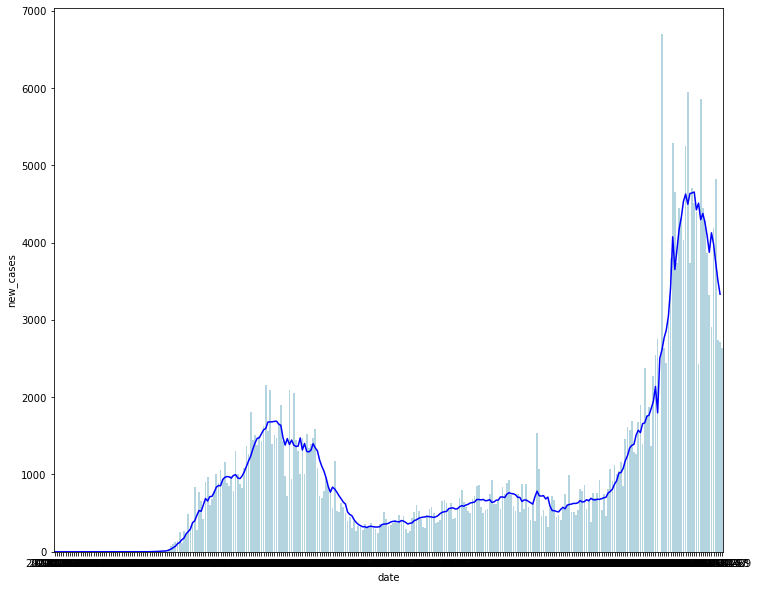

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue');


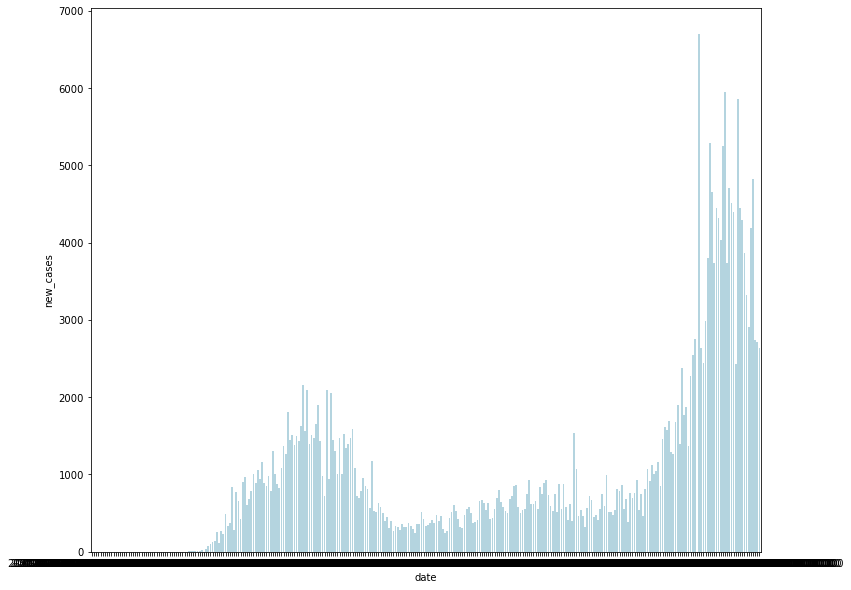

In [14]:
import datetime as dt
import matplotlib.dates as mdates

left = dt.date(2020,1,24)
right = dt.date(2020,10,31)
x = pd.to_datetime(cook['date'])
y = cook['7-day_avg_new']
y2 = cook['new_cases']

fig, ax = plt.subplots(figsize=(12,10))
ax1=sns.lineplot(x,y, color = 'blue')
ax2=sns.barplot(x,y2, color = 'lightblue');

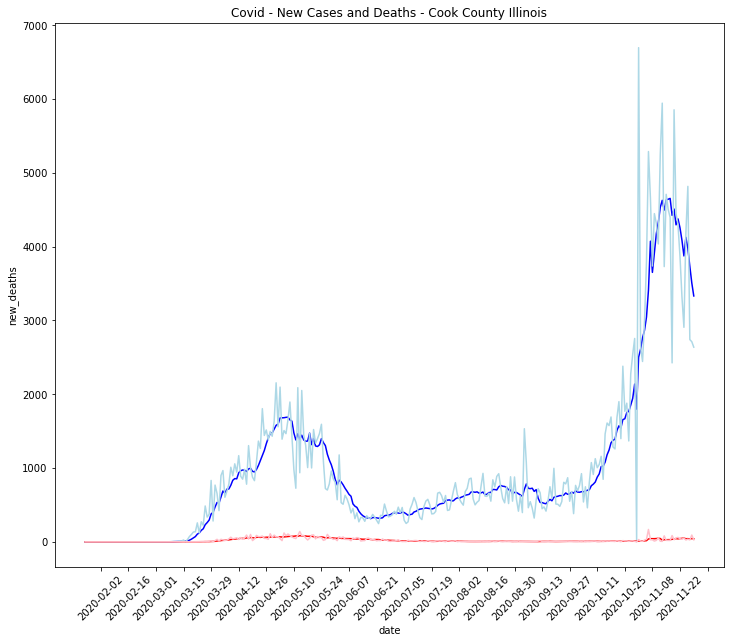

In [15]:
import numpy as np

x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.lineplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');



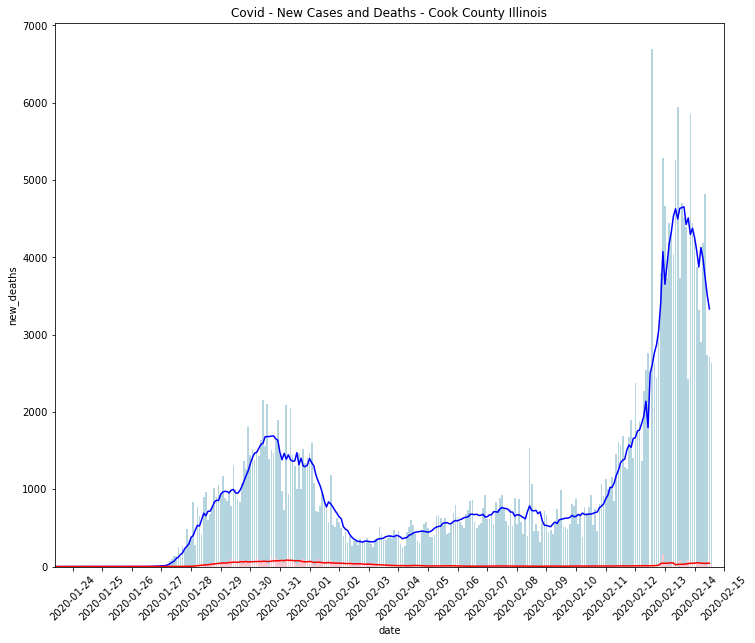

In [16]:
x = cook['date']
y = cook['7-day_avg_new']
y2 = cook['new_cases']
y3 = cook['7-day_avg_death']
y4 = cook['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.barplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Cook County Illinois');

In [17]:
illinois = pd.read_sql('''WITH cte as (SELECT date, state, 
                    cases - LAG (cases,1) OVER (PARTITION BY state ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY state ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM counties
                    ORDER BY state)
                    
                    SELECT date, state, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois'
                    ORDER BY date''',conn)
illinois

,date,state,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,NaN,1,NaN,NaN,0.0,NaN
1,2020-01-25,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
2,2020-01-26,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
3,2020-01-27,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
4,2020-01-28,Illinois,0.0,1,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...
24967,2020-11-29,Illinois,3291.0,3905,389.000000,107.0,115.0,12.428571
24968,2020-11-29,Illinois,34779.0,38684,4967.000000,448.0,563.0,73.142857
24969,2020-11-29,Illinois,-35074.0,3610,434.285714,-480.0,83.0,10.714286
24970,2020-11-29,Illinois,15338.0,18948,2551.142857,179.0,262.0,34.571429


In [18]:
df = pd.read_sql('''SELECT * FROM states WHERE state = 'Illinois' ORDER BY date desc LIMIT 50;''',conn)
df

,date,state,fips,cases,deaths
0,2020-11-22,Illinois,17,657402,12064
1,2020-11-21,Illinois,17,647474,11967
2,2020-11-20,Illinois,17,635823,11814
3,2020-11-19,Illinois,17,622869,11671
4,2020-11-18,Illinois,17,608056,11488
5,2020-11-17,Illinois,17,599358,11327
6,2020-11-16,Illinois,17,586569,11217
7,2020-11-15,Illinois,17,574722,11170
8,2020-11-14,Illinois,17,564086,11098
9,2020-11-13,Illinois,17,553083,10907


In [19]:
illinois = pd.read_sql('''WITH cte as (SELECT date, state, 
                    cases - LAG (cases,1) OVER (PARTITION BY state ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY state ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM states
                    ORDER BY state)
                    
                    SELECT date, state, new_cases, cumulative_cases,
                    AVG(new_cases) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois'
                    ORDER BY date''',conn)
illinois

,date,state,new_cases,cumulative_cases,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,NaN,1,NaN,NaN,0,NaN
1,2020-01-25,Illinois,0.0,1,0.000000,0.0,0,0.000000
2,2020-01-26,Illinois,0.0,1,0.000000,0.0,0,0.000000
3,2020-01-27,Illinois,0.0,1,0.000000,0.0,0,0.000000
4,2020-01-28,Illinois,0.0,1,0.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...
299,2020-11-18,Illinois,8698.0,608056,11854.857143,161.0,11488,97.571429
300,2020-11-19,Illinois,14813.0,622869,12144.142857,183.0,11671,116.571429
301,2020-11-20,Illinois,12954.0,635823,11820.000000,143.0,11814,129.571429
302,2020-11-21,Illinois,11651.0,647474,11912.571429,153.0,11967,124.142857


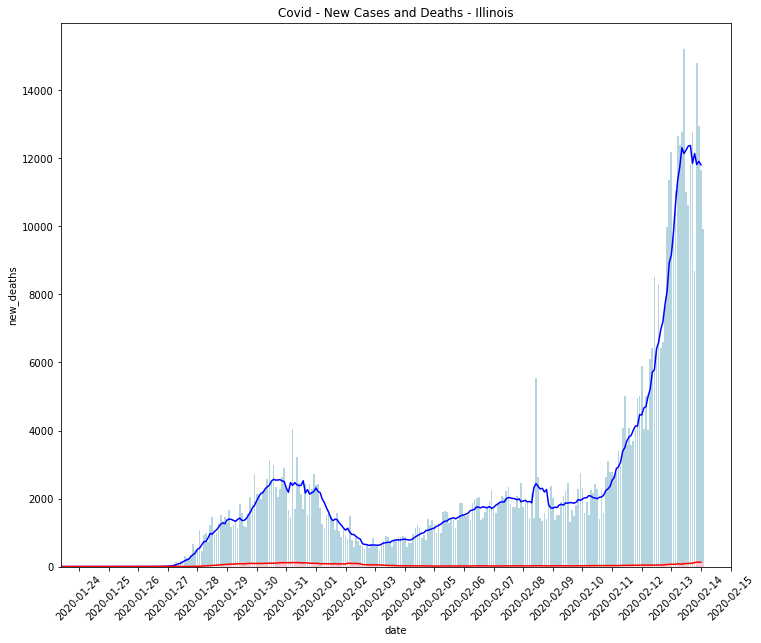

In [20]:
x = illinois['date']
y = illinois['7-day_avg_new']
y2 = illinois['new_cases']
y3 = illinois['7-day_avg_death']
y4 = illinois['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.barplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.barplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Illinois');

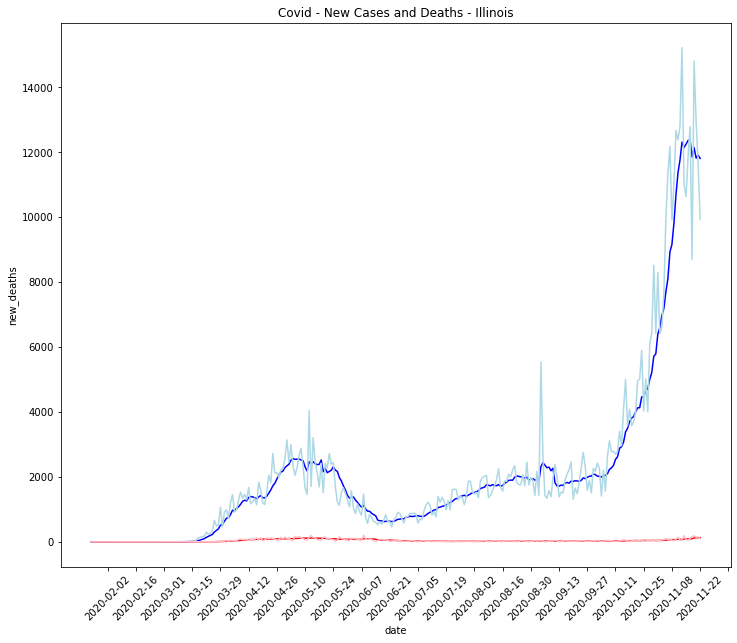

In [21]:
x = illinois['date']
y = illinois['7-day_avg_new']
y2 = illinois['new_cases']
y3 = illinois['7-day_avg_death']
y4 = illinois['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
sns.lineplot(x,y2, color = 'lightblue')
sns.lineplot(x,y3, color = 'red')
sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - New Cases and Deaths - Illinois');

In [22]:
il_pop = 12700000

illinois = pd.read_sql('''WITH cte as (SELECT date, state, 
                    cases - LAG (cases,1) OVER (PARTITION BY state ORDER BY date) as 'new_cases',
                    cases as 'cumulative_cases',
                    deaths - LAG (deaths,1) OVER (PARTITION BY state ORDER BY date) as 'new_deaths',
                    deaths as 'cumulative_deaths'
                    FROM states
                    ORDER BY state)
                    
                    SELECT date, state, new_cases, cumulative_cases, ROUND(cumulative_cases/12700,1) as 'cases_per_million',
                    AVG(new_cases) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_new',
                    new_deaths, cumulative_deaths,
                    AVG(new_deaths) OVER (PARTITION BY state ORDER BY date ASC rows 6 PRECEDING) as '7-day_avg_death'
                    FROM cte
                    WHERE state = 'Illinois'
                    ORDER BY date''',conn)
illinois

,date,state,new_cases,cumulative_cases,cases_per_million,7-day_avg_new,new_deaths,cumulative_deaths,7-day_avg_death
0,2020-01-24,Illinois,NaN,1,0.0,NaN,NaN,0,NaN
1,2020-01-25,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
2,2020-01-26,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
3,2020-01-27,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
4,2020-01-28,Illinois,0.0,1,0.0,0.000000,0.0,0,0.000000
...,...,...,...,...,...,...,...,...,...
299,2020-11-18,Illinois,8698.0,608056,47.0,11854.857143,161.0,11488,97.571429
300,2020-11-19,Illinois,14813.0,622869,49.0,12144.142857,183.0,11671,116.571429
301,2020-11-20,Illinois,12954.0,635823,50.0,11820.000000,143.0,11814,129.571429
302,2020-11-21,Illinois,11651.0,647474,50.0,11912.571429,153.0,11967,124.142857


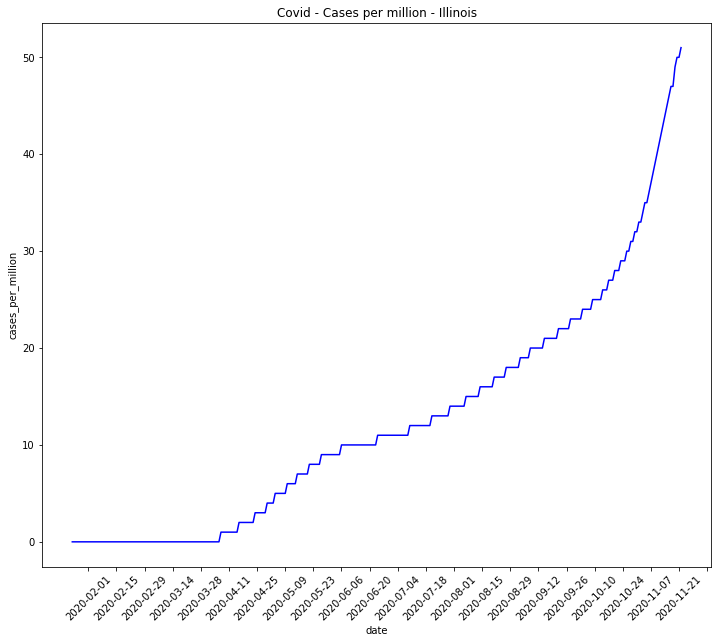

In [23]:
x = illinois['date']
y = illinois['cases_per_million']
# y2 = illinois['new_cases']
# y3 = illinois['7-day_avg_death']
# y4 = illinois['new_deaths']

fig, ax = plt.subplots(figsize=(12,10))
sns.lineplot(x,y, color = 'blue')
# sns.lineplot(x,y2, color = 'lightblue')
# sns.lineplot(x,y3, color = 'red')
# sns.lineplot(x,y4, color = 'pink');
plt.xticks((np.arange(8, 330, step=14)),rotation=45)
plt.title('Covid - Cases per million - Illinois');